# PETSc ARG

## Setup

First, check if you are at the correct project environment.

In [27]:
using Pkg
Pkg.status()

Status `~/Desktop/petsc-arg/ExperimentalDesign/Project.toml`
  [336ed68f] CSV v0.7.7
  [a93c6f00] DataFrames v0.21.5
  [31c24e10] Distributions v0.23.6
  [ffbed154] DocStringExtensions v0.8.2
  [e30172f5] Documenter v0.24.11
  [4babbea4] ExperimentalDesign v0.3.3
  [38e38edf] GLM v1.3.9
  [91a5bcdd] Plots v1.5.7
  [27ebfcd6] Primes v0.5.0
  [2913bbd2] StatsBase v0.33.0
  [3eaba693] StatsModels v0.6.12
  [f3b207a7] StatsPlots v0.14.6
  [37e2e46d] LinearAlgebra 
  [56ddb016] Logging 
  [9a3f8284] Random 
  [8dfed614] Test 


Then check if all packages are installed and up to date:

In [28]:
Pkg.update()

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


  Installed ColorTypes ───── v0.10.8
  Installed DataStructures ─ v0.17.20
  Installed StatsPlots ───── v0.14.7
  Installed Distributions ── v0.23.8
  Installed x264_jll ─────── v2020.7.14+1
  Installed LibVPX_jll ───── v1.9.0+0
  Installed Plots ────────── v1.5.8
  Installed DataFrames ───── v0.21.6
  Installed FFMPEG_jll ───── v4.3.1+1
######################################################################### 100,0%##O=#  #                                                                       
######################################################################### 100,0%##O=#  #                                                                       
######################################################################### 100,0%##O#- #                                                                                   1,3%            16,0%
   Updating `~/Desktop/petsc-arg/ExperimentalDesign/Project.toml`
  [a93c6f00] ↑ DataFrames v0.21.5 ⇒ v0.21.6
  [31c24e10] ↑ Distributions v0.23.6 ⇒

In [2]:
using ExperimentalDesign, StatsModels, GLM, DataFrames, Distributions, Random, StatsPlots, CSV

┌ Info: Precompiling ExperimentalDesign [4babbea4-9e7d-11e9-116f-e1ada04bd296]
└ @ Base loading.jl:1260
┌ Info: Precompiling GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1260
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1260
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1260


# Designs with Categorical Factors

## Target Application Parameters

In [14]:
cmd_prefix = ["singularity", "exec", "--nv", "../container/petsc-gpu.sif", "make", "-s", "-C", "../src"]
dev = "core"
np = 4
res = 100
repetitions = 3

3

## Response Function

In [15]:
# x is a set of flags
function y(x)
    parameters = []
    for i in 1:length(x)
        push!(parameters, rstrip(string(uppercase(string(keys(x)[i])), "=", x[i], " ")))
    end
    
    cmd = `$cmd_prefix $[dev, "NP=$np", "RES=$res"] $parameters`

    main_stage = parse(Float64, chomp(read(cmd, String)))
    return main_stage
end

y (generic function with 1 method)

## Full Factorial Design

In [20]:
factorial_design = FullFactorial((ksp_type = ["cg", "gmres", "fcg", "tcqmr", "cgs", "bcgs", "tfqmr", "cr", "gcr"],
        pc_type = ["jacobi", "sor", "bjacobi", "mg"]), @formula(y ~ ksp_type + pc_type))

FullFactorial
Dimension: (36, 2)
Factors: (ksp_type = ["cg", "gmres", "fcg", "tcqmr", "cgs", "bcgs", "tfqmr", "cr", "gcr"], pc_type = ["jacobi", "sor", "bjacobi", "mg"])
Formula: y ~ ksp_type + pc_type
Design Matrix:
36×2 DataFrame
│ Row │ ksp_type │ pc_type │
│     │ String   │ String  │
├─────┼──────────┼─────────┤
│ 1   │ cg       │ jacobi  │
│ 2   │ gmres    │ jacobi  │
│ 3   │ fcg      │ jacobi  │
│ 4   │ tcqmr    │ jacobi  │
│ 5   │ cgs      │ jacobi  │
│ 6   │ bcgs     │ jacobi  │
│ 7   │ tfqmr    │ jacobi  │
│ 8   │ cr       │ jacobi  │
│ 9   │ gcr      │ jacobi  │
│ 10  │ cg       │ sor     │
⋮
│ 26  │ cr       │ bjacobi │
│ 27  │ gcr      │ bjacobi │
│ 28  │ cg       │ mg      │
│ 29  │ gmres    │ mg      │
│ 30  │ fcg      │ mg      │
│ 31  │ tcqmr    │ mg      │
│ 32  │ cgs      │ mg      │
│ 33  │ bcgs     │ mg      │
│ 34  │ tfqmr    │ mg      │
│ 35  │ cr       │ mg      │
│ 36  │ gcr      │ mg      │

In [21]:
factorial_design.matrix[!, :response] = y.(eachrow(factorial_design.matrix))

results = copy(factorial_design.matrix)

for i in 1:repetitions
    factorial_design.matrix[!, :response] = y.(eachrow(factorial_design.matrix))
    append!(results, copy(factorial_design.matrix))
end

# Save CSV
CSV.write("repeated_measurements_full.csv", results)

"repeated_measurements_full.csv"

In [22]:
print(factorial_design)

FullFactorial
Dimension: (36, 3)
Factors: (ksp_type = ["cg", "gmres", "fcg", "tcqmr", "cgs", "bcgs", "tfqmr", "cr", "gcr"], pc_type = ["jacobi", "sor", "bjacobi", "mg"])
Formula: y ~ ksp_type + pc_type
Design Matrix:
36×3 DataFrame
│ Row │ ksp_type │ pc_type │ response │
│     │ String   │ String  │ Float64  │
├─────┼──────────┼─────────┼──────────┤
│ 1   │ cg       │ jacobi  │ 0.075633 │
│ 2   │ gmres    │ jacobi  │ 0.17118  │
│ 3   │ fcg      │ jacobi  │ 0.09418  │
│ 4   │ tcqmr    │ jacobi  │ 0.09769  │
│ 5   │ cgs      │ jacobi  │ 0.086916 │
│ 6   │ bcgs     │ jacobi  │ 0.11849  │
│ 7   │ tfqmr    │ jacobi  │ 0.1161   │
│ 8   │ cr       │ jacobi  │ 0.073173 │
│ 9   │ gcr      │ jacobi  │ 0.30456  │
│ 10  │ cg       │ sor     │ 0.084158 │
│ 11  │ gmres    │ sor     │ 0.094154 │
│ 12  │ fcg      │ sor     │ 0.09609  │
│ 13  │ tcqmr    │ sor     │ 0.17292  │
│ 14  │ cgs      │ sor     │ 0.068118 │
│ 15  │ bcgs     │ sor     │ 0.061435 │
│ 16  │ tfqmr    │ sor     │ 0.068605 │
│ 17  │ 

## Sampling Random Experiments

In [3]:
design_distribution = DesignDistribution((ksp_type = CategoricalFactor(["cg", "gmres", "fcg", "tcqmr", "cgs", "bcgs", "tfqmr", "cr", "gcr"]),
        pc_type = CategoricalFactor(["jacobi", "sor", "bjacobi", "mg"])))

DesignDistribution
Formula: 0 ~ ksp_type + pc_type
Factor Distributions:
ksp_type: CategoricalFactor(
values: ["cg", "gmres", "fcg", "tcqmr", "cgs", "bcgs", "tfqmr", "cr", "gcr"]
distribution: DiscreteUniform(a=1, b=9)
)

pc_type: CategoricalFactor(
values: ["jacobi", "sor", "bjacobi", "mg"]
distribution: DiscreteUniform(a=1, b=4)
)


In [31]:
design = rand(design_distribution, 300)
f = @formula 0 ~ ksp_type + pc_type
optimal_design = OptimalDesign(design, f, 10)

OptimalDesign
Dimension: (10, 2)
Factors: (ksp_type = CategoricalFactor(
values: ["cg", "gmres", "fcg", "tcqmr", "cgs", "bcgs", "tfqmr", "cr", "gcr"]
distribution: DiscreteUniform(a=1, b=9)
)
, pc_type = CategoricalFactor(
values: ["jacobi", "sor", "bjacobi", "mg"]
distribution: DiscreteUniform(a=1, b=4)
)
)
Formula: 0 ~ ksp_type + pc_type
Selected Candidate Rows: [215, 231, 141, 172, 212, 200, 187, 206, 3, 56]
Optimality Criteria: Dict(:D => 0.00426276981725733)
Design Matrix:
10×2 DataFrame
│ Row │ ksp_type │ pc_type │
│     │ String   │ String  │
├─────┼──────────┼─────────┤
│ 1   │ cgs      │ sor     │
│ 2   │ gcr      │ mg      │
│ 3   │ tfqmr    │ bjacobi │
│ 4   │ gmres    │ jacobi  │
│ 5   │ cr       │ bjacobi │
│ 6   │ tcqmr    │ sor     │
│ 7   │ cgs      │ mg      │
│ 8   │ bcgs     │ jacobi  │
│ 9   │ cg       │ bjacobi │
│ 10  │ fcg      │ bjacobi │

Plot design

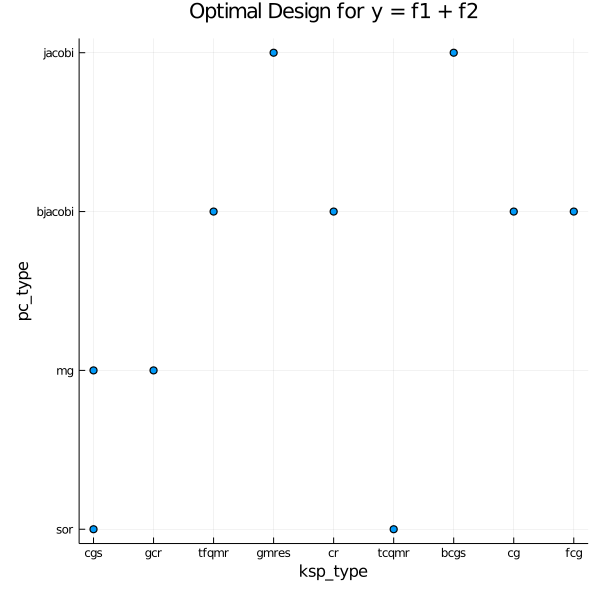

In [32]:
@df optimal_design.matrix scatter(:ksp_type,
    :pc_type,
    size = (600, 600),
    xlabel = "ksp_type",
    ylabel = "pc_type",
    legend = false,
    title = "Optimal Design for y = f1 + f2")

In [9]:
optimal_design.matrix[!, :response] = y.(eachrow(optimal_design.matrix))
results = copy(optimal_design.matrix)

for i in 1:repetitions
    optimal_design.matrix[!, :response] = y.(eachrow(optimal_design.matrix))
    append!(results, copy(optimal_design.matrix))
end

# Save CSV
CSV.write("repeated_measurements_random.csv", results)

UndefVarError: UndefVarError: optimal_design not defined